In [134]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [135]:


# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define a small neural network model
class SmallModel(nn.Module):
    def __init__(self):
        super(SmallModel, self).__init__()
        self.fc1 = nn.Linear(20, 30)
        self.fc2 = nn.Linear(30, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SmallModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Epoch 1/10, Loss: 0.6616537570953369
Epoch 2/10, Loss: 0.672048807144165
Epoch 3/10, Loss: 0.4419587552547455
Epoch 4/10, Loss: 0.28375646471977234
Epoch 5/10, Loss: 0.21836839616298676
Epoch 6/10, Loss: 0.31707602739334106
Epoch 7/10, Loss: 0.4600712060928345
Epoch 8/10, Loss: 0.12176411598920822
Epoch 9/10, Loss: 0.2812472879886627
Epoch 10/10, Loss: 0.18903423845767975
Total number of parameters: 692


In [136]:
x_samples = X[:100]
y_samples = y[:100]

In [137]:
true_hessian = compute_hessian(model, criterion, x_samples, y_samples)
true_vals, true_vecs = np.linalg.eigh(true_hessian)
predicted_hessian = hessian(model, criterion, data=(x_samples, y_samples), cuda=False)
pred_vals, pred_vecs = predicted_hessian.eigenvalues(maxIter=500, top_n=10)

In [138]:
# Flattening the pred_vecs
def flatten(vec):
    final = []
    for part in vec:
        final += np.array(part).flatten().tolist()
    return np.array(final)



flat_pred_vecs = [flatten(vec) for vec in pred_vecs]
flat_true_vecs = true_vecs
flat_pred_vecs = [vec / np.linalg.norm(vec) for vec in flat_pred_vecs]
flat_true_vecs = [vec / np.linalg.norm(vec) for vec in flat_true_vecs]

In [139]:
# Find the error in predicting the eigenvectors
dots = []
for vec in flat_pred_vecs:
    dots.append(np.max([(np.dot(vec, true_vec)) for true_vec in flat_true_vecs]))

print(f'Mean dots in eigenvectors: {np.mean(dots)}')

Mean dots in eigenvectors: 0.12305668728323782


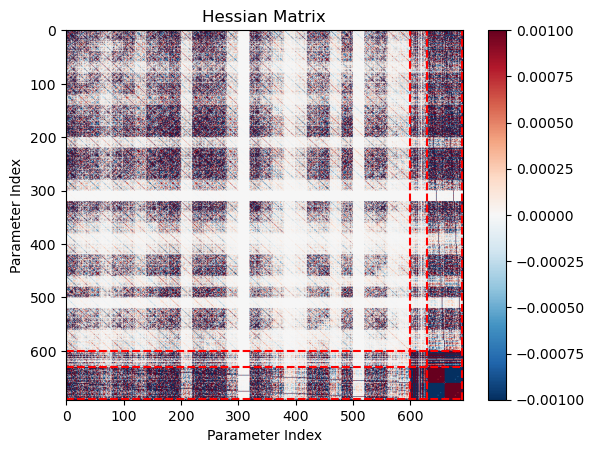

In [140]:
%matplotlib inline
plot_hessian(model, criterion, x_samples, y_samples)
plt.show()

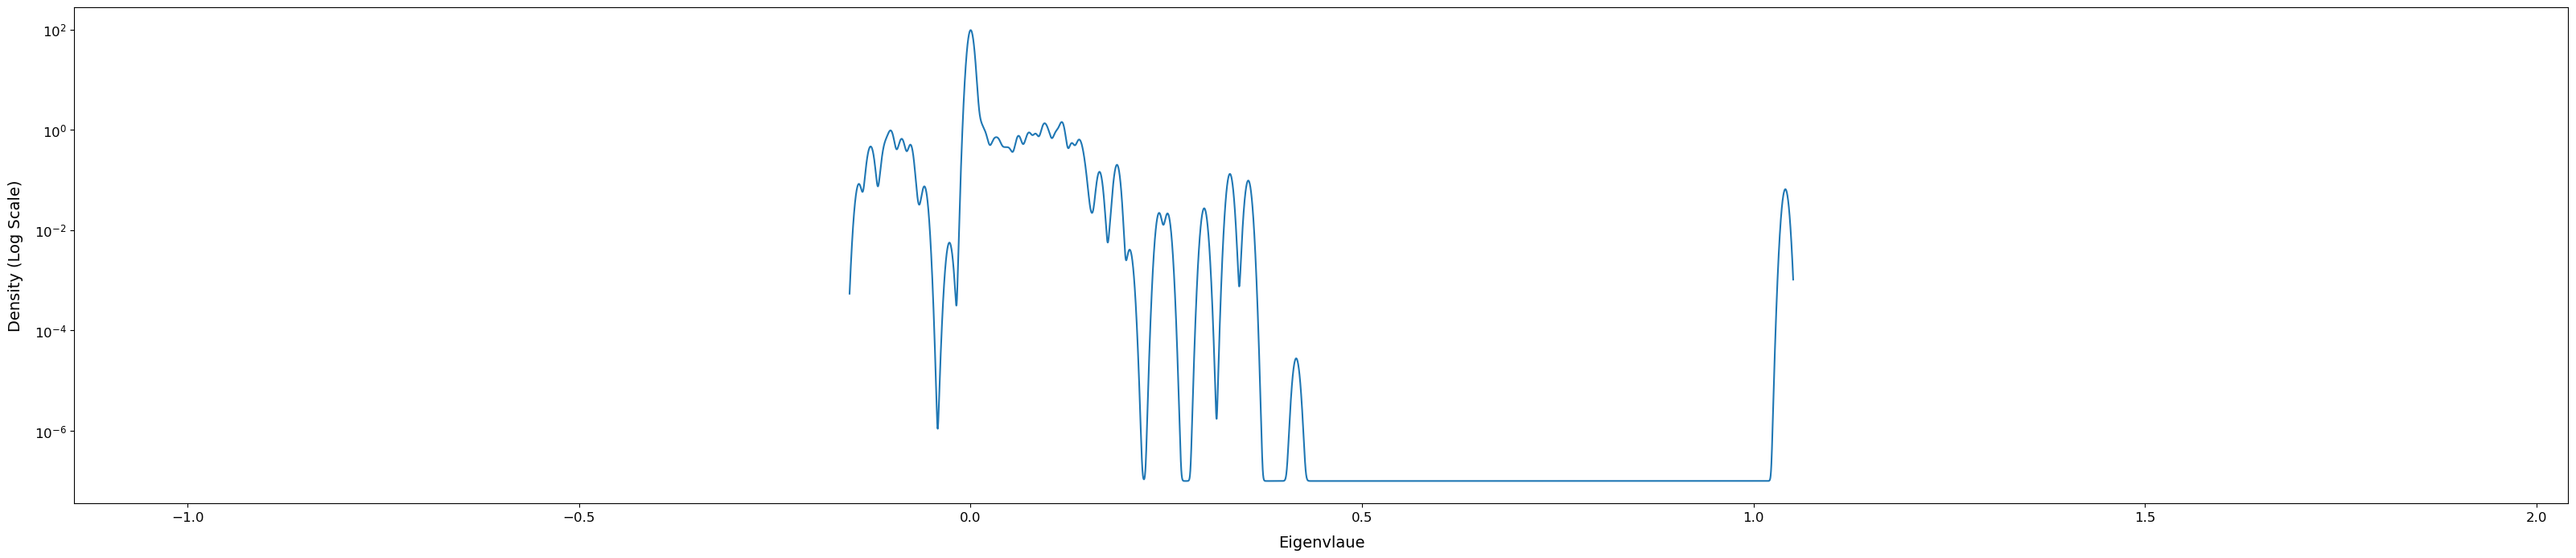

In [141]:
get_esd_plot(*predicted_hessian.density())

In [142]:
# Get true eigenvalue density
